# Matching entre Itens com Distância Euclidiana (L2)

Notebook 4 da série: mostra como usar distância euclidiana para aproximar perfis e itens quando a proximidade absoluta importa (ex.: empresas ↔ necessidade, usuário ↔ vaga, paciente ↔ tratamento).


## 1. Introdução
- **O que é L2?** Distância euclidiana mede o “comprimento” do vetor que liga dois pontos.
- **Intuição geométrica:** círculos concêntricos ao redor de um ponto representam fronteiras de proximidade.
- **Quando usar?** Quando valores absolutos importam (ex.: budget, temperatura, nível de estoque) e precisamos de vizinhos realmente próximos.
- **Comparação rápida:**
  - Dot product: considera magnitude + alinhamento (sensível a intensidade).
  - Cosine: foca no ângulo (ignora magnitude).
  - L2: considera distância direta (ótimo para “quão perto” algo está).


## 2. Teoria leve
- **Fórmula:** `d(a, b) = sqrt(Σ (a_i - b_i)^2)`.
- **Visualização:** círculos (ou esferas) concêntricos representam regiões de distância crescente.
- **Clusters:** quando dados se agrupam por proximidade absoluta, L2 separa bem grupos naturais.


### Visualização com círculos de raio crescente


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

np.random.seed(32)
plt.style.use("seaborn-v0_8")


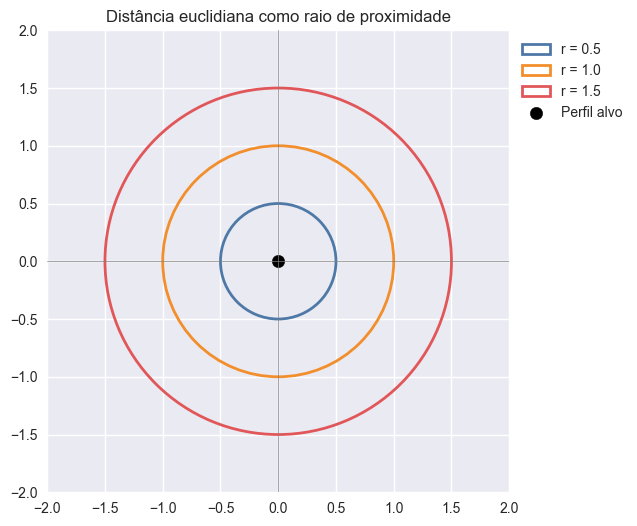

In [2]:
center = np.array([0.0, 0.0])
radii = [0.5, 1.0, 1.5]
colors = ["#4E79A7", "#F28E2B", "#E15759"]

fig, ax = plt.subplots(figsize=(6, 6))
for r, color in zip(radii, colors):
    circle = plt.Circle(center, r, color=color, fill=False, linewidth=2, label=f"r = {r}")
    ax.add_artist(circle)

ax.scatter(center[0], center[1], c="#000000", s=80, label="Perfil alvo")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_title("Distância euclidiana como raio de proximidade")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


### Exemplo de clusters
Vamos simular 3 grupos distintos em 2D para mostrar como L2 captura proximidade absoluta.


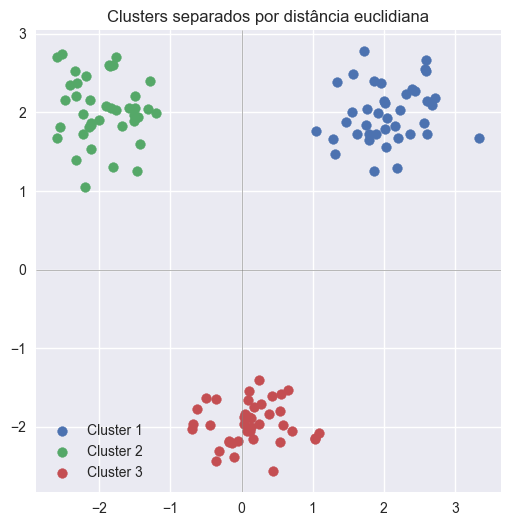

In [3]:
cluster_centers = np.array([[2, 2], [-2, 2], [0, -2]])
points = []
labels = []
for idx, center in enumerate(cluster_centers):
    pts = center + np.random.randn(40, 2) * 0.4
    points.append(pts)
    labels.extend([f"Cluster {idx+1}"] * len(pts))

points = np.vstack(points)

fig, ax = plt.subplots(figsize=(6, 6))
for label in np.unique(labels):
    idxs = [i for i, l in enumerate(labels) if l == label]
    ax.scatter(points[idxs, 0], points[idxs, 1], label=label)

ax.set_title("Clusters separados por distância euclidiana")
ax.axhline(0, color='gray', linewidth=0.4)
ax.axvline(0, color='gray', linewidth=0.4)
ax.legend()
plt.show()


## 3. Demonstração prática
Cenário: temos um “perfil ideal” (necessidade de uma empresa) e uma base de empresas com atributos vetorizados. Queremos saber quais empresas estão mais próximas em L2.


In [4]:
NUM_COMPANIES = 8
EMBED_DIM = 5

company_ids = [f"Empresa {chr(65+i)}" for i in range(NUM_COMPANIES)]
company_embeddings = np.abs(np.random.randn(NUM_COMPANIES, EMBED_DIM))

# Perfil ideal: combina requisitos (ex.: orçamento, maturidade tech, impacto social etc.)
ideal_profile = np.array([0.8, 1.2, 0.5, 1.0, 0.6])

companies_df = pd.DataFrame(company_embeddings, columns=[f"dim_{i+1}" for i in range(EMBED_DIM)])
companies_df.insert(0, "company_id", company_ids)
companies_df


,company_id,dim_1,dim_2,dim_3,dim_4,dim_5
0,Empresa A,0.384600,1.065372,0.024687,1.736772,1.102200
1,Empresa B,0.503151,1.160094,0.074259,0.386716,0.966510
2,Empresa C,2.037521,1.800809,0.905255,0.078456,1.174947
3,Empresa D,2.896559,0.197709,1.098334,0.932406,1.231814
4,Empresa E,0.790010,0.755901,0.958303,2.212721,0.134932
5,Empresa F,0.439709,0.813941,0.511093,0.061951,0.020759
6,Empresa G,0.632396,1.069787,0.809503,0.203807,0.135941
7,Empresa H,0.811003,0.118196,0.330362,1.477091,0.060838


In [5]:
def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.linalg.norm(a - b))


def rank_by_l2(profile: np.ndarray, embeddings: np.ndarray, ids: list[str], top_k: int = None) -> pd.DataFrame:
    distances = [euclidean_distance(profile, emb) for emb in embeddings]
    ranking = pd.DataFrame({"company_id": ids, "distance_l2": distances})
    ranking = ranking.sort_values(by="distance_l2", ascending=True)
    if top_k:
        ranking = ranking.head(top_k)
    ranking = ranking.reset_index(drop=True)
    return ranking

l2_ranking = rank_by_l2(ideal_profile, company_embeddings, company_ids)
l2_ranking


,company_id,distance_l2
0,Empresa B,0.883976
1,Empresa G,0.995044
2,Empresa A,1.100746
3,Empresa F,1.222469
4,Empresa H,1.310538
5,Empresa E,1.447186
6,Empresa C,1.799019
7,Empresa D,2.482319


> **Leitura do ranking:** empresas com distância menor estão mais próximas do perfil desejado. Valores podem ser interpretados como “erro” ou “gap” entre necessidade e oferta.


### Visualização com PCA
Projete os vetores em 2D para visualizar clusters e proximidade (apenas para fins explicativos).


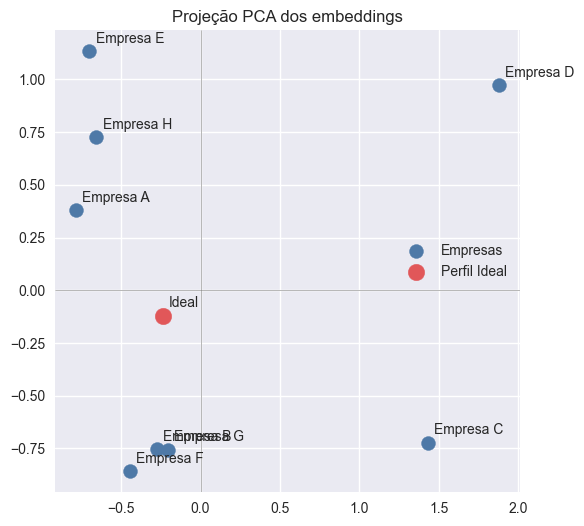

In [6]:
pca = PCA(n_components=2)
pca_points = pca.fit_transform(np.vstack([company_embeddings, ideal_profile]))
company_points = pca_points[:-1]
ideal_point = pca_points[-1]

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(company_points[:, 0], company_points[:, 1], c="#4E79A7", s=100, label="Empresas")
for idx, cid in enumerate(company_ids):
    ax.annotate(cid, (company_points[idx, 0] + 0.04, company_points[idx, 1] + 0.04))

ax.scatter(ideal_point[0], ideal_point[1], c="#E15759", s=140, label="Perfil Ideal")
ax.annotate("Ideal", (ideal_point[0] + 0.04, ideal_point[1] + 0.04))
ax.set_title("Projeção PCA dos embeddings")
ax.axhline(0, color='gray', linewidth=0.4)
ax.axvline(0, color='gray', linewidth=0.4)
ax.legend()
plt.show()


## 4. Implementação Python (função reutilizável)


In [7]:
def l2_match(profile: np.ndarray, candidates: pd.DataFrame, top_k: int = 3) -> pd.DataFrame:
    embedding_cols = [col for col in candidates.columns if col.startswith("dim_")]
    candidate_matrix = candidates[embedding_cols].values
    ranking = rank_by_l2(profile, candidate_matrix, candidates["company_id"].tolist(), top_k)
    return ranking

l2_match(ideal_profile, companies_df, top_k=3)


,company_id,distance_l2
0,Empresa B,0.883976
1,Empresa G,0.995044
2,Empresa A,1.100746


## 5. Simulação pgvector (SQL)
Usando pgvector com `vector_l2_ops` e operador `<->` (distância euclidiana).


```sql
-- 1. Tabela para empresas ou perfis
CREATE TABLE company_profiles (
    id SERIAL PRIMARY KEY,
    nome TEXT,
    embedding vector(5)
);

-- 2. Inserções de exemplo
INSERT INTO company_profiles (nome, embedding)
VALUES
  ('Empresa A', '[0.4, 1.1, 0.3, 0.8, 0.5]'),
  ('Empresa B', '[1.2, 0.5, 0.7, 0.9, 0.4]'),
  ('Empresa C', '[0.9, 1.4, 0.4, 1.1, 0.6]');

-- 3. Índice HNSW para distância L2
CREATE INDEX company_profiles_embedding_hnsw
ON company_profiles
USING hnsw (embedding vector_l2_ops);

-- 4. Query de matching (menor <-> == mais próximo)
WITH target AS (
  SELECT '[0.8, 1.2, 0.5, 1.0, 0.6]'::vector AS embedding
)
SELECT c.nome, c.embedding, c.embedding <-> target.embedding AS distancia
FROM company_profiles c, target
ORDER BY distancia ASC
LIMIT 3;
```



## 6. Expansão real
- **Concatenar embeddings + atributos numéricos:** combine vetores semânticos (texto) com features numéricas (faturamento, tamanho, localização codificada).
- **Escalonamento:** normalize cada feature (z-score ou min-max) antes de calcular L2 para evitar que uma dimensão domine.
- **Pré-processamento:** limpe outliers, preencha valores faltantes e considere PCA ou autoencoders para reduzir dimensionalidade antes do matching.
- **Pós-processamento:** aplique filtros de negócio (cidade, faixa de preço) e penalidades personalizadas após o ranking L2.


## 7. Conclusão
- Distância euclidiana mede “o quão perto” dois vetores estão em termos absolutos.
- Ideal para matching de perfis com restrições rígidas, métricas físicas ou scores já normalizados.
- pgvector suporta `vector_l2_ops` e operador `<->`, facilitando consultas rápidas.
- Combine com pré-processamento cuidadoso e filtros de negócio para resultados consistentes.
